In [1]:
import pandas as pd
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

import keras
from keras.utils import to_categorical
from keras.constraints import maxnorm
from keras.models import Sequential, load_model, Model
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import (Dense,
                          Activation,
                          Dropout, Conv2D,
                          ZeroPadding2D,
                          MaxPooling2D,
                          Flatten,
                          PReLU,
                          BatchNormalization,
                          Input,
                          Add,
                          AveragePooling2D)

from keras.regularizers import l2
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler, TensorBoard
from keras.initializers import glorot_uniform
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def LoadData():
    train = pd.read_csv('./data/train.csv')
    test = pd.read_csv('./data/test.csv')
    Y_train = np.array(train['label'])
    Y_train = to_categorical(Y_train)
    
    X = np.array(train['feature'])
    X_train = []
    for i in range(X.shape[0]):
        x = np.array(X[i].split(' '))
        x = x.astype(np.int)
        X_train.append(x)
    X_train = np.array(X_train)
    X_train = X_train.reshape(X_train.shape[0],48,48,1)/255
    
    X = np.array(test['feature'])
    X_test = []
    for i in range(X.shape[0]):
        x = np.array(X[i].split(' '))
        x = x.astype(np.int)
        X_test.append(x)
    X_test = np.array(X_test)
    X_test = X_test.reshape(X_test.shape[0],48,48,1)/255
    
    return X_train, Y_train, X_test

In [3]:
labels = {0: "angry", 1:"disgust", 2:"fear", 3:"happy", 4:"sad", 5:"surprise", 6:"neutral"}
X_train, Y_train, X_test = LoadData()

In [4]:
def model_create():
    
    filter_pixel = 3
    input_shape = (48,48,1)
    
    model = Sequential()
    model.add(Conv2D(256, kernel_size=(filter_pixel, filter_pixel), padding="same",
                 activation='relu',
                 input_shape=input_shape))
    model.add(BatchNormalization())

    model.add(Conv2D(256, kernel_size=(filter_pixel, filter_pixel), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(512, kernel_size=(2,2), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(256, kernel_size=(filter_pixel, filter_pixel), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Conv2D(256, kernel_size=(filter_pixel, filter_pixel), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    
    model.add(Conv2D(256, kernel_size=(filter_pixel, filter_pixel), activation='relu',padding="same"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())

    model.add(Flatten())
    
    for i in range(2):
        model.add(Dense(256))
        model.add(PReLU())
        model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))
    prop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    model.compile(optimizer=prop,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [13]:
#ResNet Block
def resnet_block(inputs,num_filters=16,
                  kernel_size=3,strides=1,
                  activation='relu'):
    
    x = Conv2D(num_filters,
               kernel_size=kernel_size,
               strides=strides,padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    
    if(activation):
        x = PReLU()(x)
        
    return x

def resnet_v1(input_shape):
    inputs = Input(shape=input_shape)
    
    #first layer
    x = resnet_block(inputs)
    
    # 2-7 layers
    for i in range(6):
        a = resnet_block(inputs = x)
        b = resnet_block(inputs=a,activation=None)
        x = keras.layers.add([x,b])
        x = PReLU()(x)
        
    # out：32*32*16
    # 8-13 layers
    for i in range(6):
        if i == 0:
            a = resnet_block(inputs = x,strides=2,num_filters=32)
        else:
            a = resnet_block(inputs = x,num_filters=32)
        b = resnet_block(inputs=a,activation=None,num_filters=32)
        if i==0:
            x = Conv2D(32,kernel_size=3,strides=2,padding='same',
                       kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
            
        x = keras.layers.add([x,b])
        x = PReLU()(x)
    
    
    # out:16*16*32
    # 14-19th layers
    for i in range(6):
        if i ==0 :
            a = resnet_block(inputs = x,strides=2,num_filters=64)
        else:
            a = resnet_block(inputs = x,num_filters=64)

        b = resnet_block(inputs=a,activation=None,num_filters=64)
        if i == 0:
            x = Conv2D(64,kernel_size=3,strides=2,padding='same',
                       kernel_initializer='he_normal', kernel_regularizer=l2(1e-4))(x)
            
        x = keras.layers.add([x,b])
        x = PReLU()(x)
        
    for i in range(6):
        if i ==0 :
            a = resnet_block(inputs = x, strides=2,num_filters=128)
        else:
            a = resnet_block(inputs = x,num_filters=128)

        b = resnet_block(inputs=a,activation=None,num_filters=128)
        if i == 0:
            x = Conv2D(128,kernel_size=3,strides=2,padding='same',
                       kernel_initializer='he_normal',kernel_regularizer=l2(1e-4))(x)
            
        x = keras.layers.add([x,b])
        x = PReLU()(x)
    
    att = Dense(int(x.shape[3]), kernel_initializer=glorot_uniform(), activation='softmax')(x)
    x = Multiply()([att, x])
        
    # out:8*8*64
    # 20th layers
    x = AveragePooling2D(pool_size=2)(x)
    
    # out:4*4*64
    y = Flatten()(x)
    # out:1024
    outputs = Dense(7,activation='softmax',
                    kernel_initializer='he_normal')(y)
    
    model = Model(inputs=inputs,outputs=outputs)
    return model

In [21]:
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Lambda
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import Dense
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.models import Model
from keras.regularizers import l2


def residual_block(input,input_channels=None,
                    output_channels=None,
                  kernel_size=3,stride=1,
                  activation='relu'):
    
    if output_channels is None:
        output_channels = input.get_shape()[-1].value
    if input_channels is None:
        input_channels = output_channels // 4
        
    x = Conv2D(output_channels,
               kernel_size=kernel_size,
               strides=stride,
               padding='same',
               kernel_initializer='he_normal',
               kernel_regularizer=l2(1e-4))(input)
    x = BatchNormalization()(x)
    
    if(activation):
        x = PReLU()(x)
        
    return x


def attention_block(input, input_channels=None, output_channels=None, encoder_depth=1):
    """
    attention block
    https://arxiv.org/abs/1704.06904
    """
    p = 1
    t = 2
    r = 1

    if input_channels is None:
        input_channels = input.get_shape()[-1].value
    if output_channels is None:
        output_channels = input_channels

    # First Residual Block
    for i in range(p):
        input = residual_block(input)

    # Trunc Branch
    output_trunk = input
    for i in range(t):
        output_trunk = residual_block(output_trunk)

    # Soft Mask Branch
    ## encoder
    ### first down sampling
    output_soft_mask = MaxPool2D(padding='same')(input)  # 32x32
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)

    skip_connections = []
    for i in range(encoder_depth - 1):

        ## skip connections
        output_skip_connection = residual_block(output_soft_mask)
        skip_connections.append(output_skip_connection)

        ## down sampling
        output_soft_mask = MaxPool2D(padding='same')(output_soft_mask)
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)

    ## decoder
    skip_connections = list(reversed(skip_connections))
    for i in range(encoder_depth - 1):
        ## upsampling
        for _ in range(r):
            output_soft_mask = residual_block(output_soft_mask)
        output_soft_mask = UpSampling2D()(output_soft_mask)
        ## skip connections
        output_soft_mask = Add()([output_soft_mask, skip_connections[i]])

    ### last upsampling
    for i in range(r):
        output_soft_mask = residual_block(output_soft_mask)
    output_soft_mask = UpSampling2D()(output_soft_mask)

    ## Output
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    output_soft_mask = Conv2D(input_channels, (1, 1))(output_soft_mask)
    #output_soft_mask = Activation('sigmoid')(output_soft_mask)
    output_soft_mask = Activation('softmax')(output_soft_mask)
    
    # Attention: (1 + output_soft_mask) * output_trunk
    output = Lambda(lambda x: x + 1)(output_soft_mask)
    output = Multiply()([output, output_trunk])  #

    # Last Residual Block
    for i in range(p):
        output = residual_block(output)

    return output


def AttentionResNetCifar10(shape=(32, 32, 3), n_channels=32, n_classes=10):
    
    input_ = Input(shape=shape)

    for i in range(2):
        x = Conv2D(n_channels, (3, 3), padding='same')(input_)
        x = BatchNormalization()(x)
        x = PReLU()(x)
        x = MaxPool2D(pool_size=(2, 2))(x)  
        
    x = residual_block(x, input_channels=32, output_channels=128)
    x = attention_block(x, encoder_depth=2)
        
    x = residual_block(x, input_channels=128, output_channels=256, stride=2)  # 8x8
    x = attention_block(x, encoder_depth=1)

    x = residual_block(x, input_channels=256, output_channels=512, stride=2)  # 4x4
    x = attention_block(x, encoder_depth=1)

    x = residual_block(x, input_channels=512, output_channels=512)
    x = residual_block(x, input_channels=512, output_channels=512)
    x = residual_block(x, input_channels=512, output_channels=1024)
    x = residual_block(x, input_channels=1024, output_channels=1024)
    x = residual_block(x, input_channels=1024, output_channels=1024)

    x = AveragePooling2D(pool_size=(2, 2), strides=(1, 1))(x)  # 1x1
    x = Flatten()(x)
    output = Dense(n_classes, activation='softmax')(x)
    
    model = Model(input_, output)
    return model

In [22]:
cnt = 0
train_his = []
test_his = []
# model = model_create()
# model = resnet_v1((48,48,1))
# model = vgg16()
model =  AttentionResNetCifar10(shape=(48, 48, 1), n_channels=16, n_classes=7)

In [23]:
prop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam_fine = Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
adam = Adam(clipnorm=1.,clipvalue=0.5)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [24]:
outfile  = 'model32'
checkpoints = ModelCheckpoint('./model/' + outfile  + '.h5', verbose=2, 
                              monitor='val_acc', save_best_only=True, mode='auto')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, 
                              verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.001)

In [25]:
trainX, testX, trainY, testY = train_test_split(X_train,Y_train,test_size=0.1,shuffle=True)

# train_datagen = ImageDataGenerator(
#         rotation_range=20,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

train_datagen = ImageDataGenerator(
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        vertical_flip=True
        )

train_train = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    vertical_flip=True
)
test_datagen = ImageDataGenerator()

train_datagen.fit(trainX)
test_datagen.fit(testX)

In [26]:
BATCH  = 128
EPOCHS = 10

tb = TensorBoard(log_dir='./logs_2', 
                        histogram_freq=0, 
                        batch_size=32, 
                        write_graph=True, 
                        write_grads=False,
                        write_images=False,
                        embeddings_freq=0, 
                        embeddings_layer_names=None,
                        embeddings_metadata=None,
                        embeddings_data=None,
                        update_freq='epoch')

sdg = SGD(lr=0.1, decay=0.0001, momentum=0.9, clipnorm=1.)
model.compile(optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy'])

while True:
    clear_output()
#     cnt = cnt + 1
#     print(cnt * 10, "epochs")
    train = model.fit_generator(
        train_datagen.flow((trainX, trainY), batch_size=BATCH),
        steps_per_epoch=trainX.shape[0] // (4*BATCH),
        epochs=EPOCHS,
        validation_data=test_datagen.flow((testX,testY)),
        validation_steps=BATCH,
        callbacks=[checkpoints,reduce_lr,tb]
    )
    train_his.append(train.history['acc'])
    test_his.append(train.history['val_acc'])

Epoch 1/10
50/50 [==============================] - 19s 389ms/step - loss: 2.4677 - acc: 0.2520 - val_loss: 2.2626 - val_acc: 0.2586

Epoch 00001: val_acc did not improve from 0.26680
Epoch 2/10
50/50 [==============================] - 19s 389ms/step - loss: 2.4015 - acc: 0.2522 - val_loss: 2.2280 - val_acc: 0.2591

Epoch 00002: val_acc did not improve from 0.26680
Epoch 3/10
50/50 [==============================] - 19s 389ms/step - loss: 2.3649 - acc: 0.2508 - val_loss: 2.1954 - val_acc: 0.2619

Epoch 00003: val_acc did not improve from 0.26680
Epoch 4/10
50/50 [==============================] - 19s 390ms/step - loss: 2.4942 - acc: 0.2489 - val_loss: 2.4716 - val_acc: 0.2572

Epoch 00004: val_acc did not improve from 0.26680
Epoch 5/10
50/50 [==============================] - 19s 389ms/step - loss: 2.3582 - acc: 0.2484 - val_loss: 2.5171 - val_acc: 0.2594

Epoch 00005: val_acc did not improve from 0.26680
Epoch 6/10
50/50 [==============================] - 19s 388ms/step - loss: 2.370

KeyboardInterrupt: 

In [ ]:
model.save('temp.h5')

In [ ]:
while True:
    clear_output()
    cnt = cnt + 1
    print(cnt)
    train = model.fit(x=trainX, 
                      y=trainY,
                      validation_data=(testX, testY),
                      batch_size=128,
                      epochs=10,
                      verbose=1,
                      callbacks=[checkpoints,reduce_lr])

In [ ]:
model = load_model('temp.h5')

In [ ]:
ans = model.predict_classes(X_test).astype('int')
ans = np.column_stack([list(range(X_test.shape[0])), ans])
ans = pd.DataFrame(ans,columns=['id', 'label'])
ans.to_csv('data/'+ outfile +'.csv', index=False)

In [ ]:
def plot_sample(X):
    plt.imshow(X.reshape(48,48),cmap="gray")

In [ ]:
for i in range(X_train.shape[0]):
    plot_sample(X_train[i])
    labels[np.argmax(Y_train[i])]

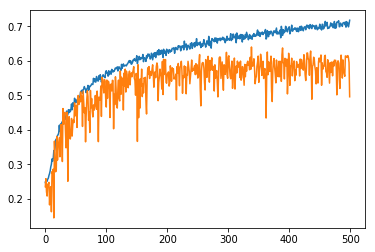

In [20]:
plt.plot(np.array(train_his).ravel())
plt.plot(np.array(test_his).ravel())

In [ ]:
## np.max(np.array(test_his).ravel())
np.argmax(np.array(test_his).ravel())